In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax import jit, random, vmap
import re

In [3]:
import examples.ice_melting_sphere.configs as cfg
from examples.ice_melting_sphere.model import PINN

cfg = cfg.Config()
pinn = PINN(config=cfg)
fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = [float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames]

In [8]:
import jax
import jax.numpy as jnp
from jax import vmap
import orbax.checkpoint as ocp
import examples.ice_melting_sphere.configs as cfg
from examples.ice_melting_sphere.model import PINN

ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/tf-logs/ice-melting/irr/2025-03-18-22-04-13/model-2000/")
state_noirr = ckpt.restore("/root/tf-logs/ice-melting/noirr2025-03-18-21-45-34/model-1000/")
params = state["params"]
params_noirr = state_noirr["params"]
cfg = cfg.Config()
pinn = PINN(config=cfg)

In [9]:
pred_radius = []
pred_radius_noirr = []
fem_radius = []
analytic_radius = []
skip_every = 100

mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t).squeeze()
    pred_noirr = vmap(pinn.net_u, in_axes=(None, 0, 0))(params_noirr, mesh, t).squeeze()
    ref_sol = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.4f}.npy")[::skip_every]
    def compute_radius(sol):
        volume_frac = jnp.mean(sol > 0.0)
        r = (3 * volume_frac / (4 * jnp.pi))**(1/3)
        return r * cfg.Lc
        # interface_idx = jnp.where((sol > -0.5) & (sol < 0.5))[0]
        # return jnp.mean(jnp.sqrt(
        #     mesh[interface_idx, 0]**2 
        #     + mesh[interface_idx, 1]**2 
        #     + mesh[interface_idx, 2]**2
        # ) * cfg.Lc)
    pred_radius.append(compute_radius(pred))
    pred_radius_noirr.append(compute_radius(pred_noirr))
    fem_radius.append(compute_radius(ref_sol))
    analytic_radius.append(cfg.R0 - cfg.LAMBDA * tic)

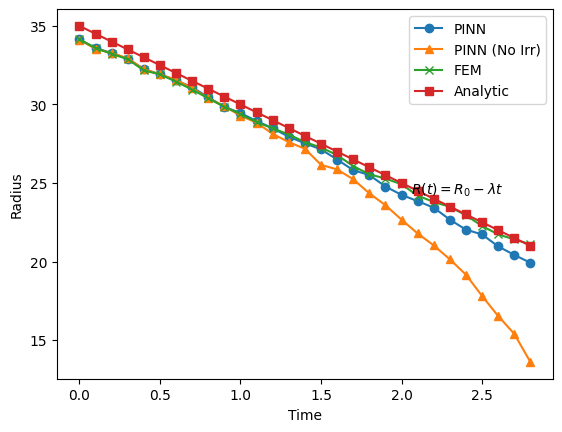

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(ts, pred_radius, label="PINN", marker="o")
ax.plot(ts, pred_radius_noirr, label="PINN (No Irr)", marker="^")
ax.plot(ts, fem_radius, label="FEM", marker="x")
ax.plot(ts, analytic_radius, label="Analytic", marker="s")

# put the formulation of the analytic solution
ax.text(0.9, 0.5, r"$R(t) = R_0 - \lambda t$", transform=ax.transAxes, ha="right")
ax.set_xlabel("Time")
ax.set_ylabel("Radius")

ax.legend()


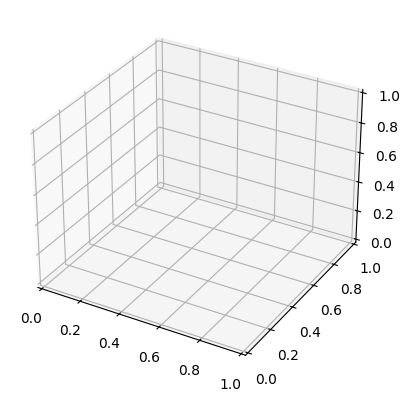

In [11]:
dphidt = pinn.net_speed(params_noirr, mesh, t)
idx = jnp.where(dphidt > 0.0)[0]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(mesh[idx, 0], mesh[idx, 1], mesh[idx, 2], c=dphidt[idx], cmap="coolwarm")

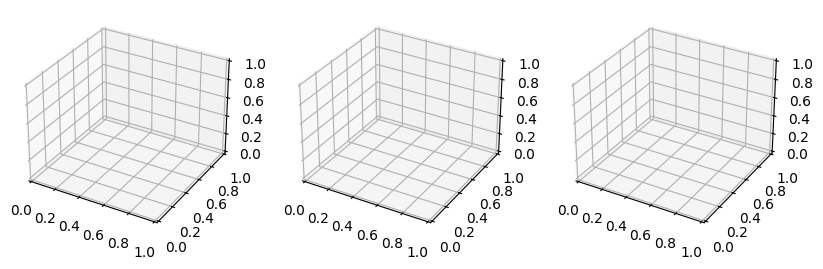

In [12]:
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
params_noirr = ckpt.restore("/root/tf-logs/ice-melting/2025-03-17-20-40-04/model-1000/")["params"]


fig, axes = plt.subplots(1, 3, figsize=(10, 3), subplot_kw={"projection": "3d"})

for i, t in enumerate([2.5, 2.75, 3.0]):
    ax = axes[i]
    t = jnp.ones_like(mesh[:, 0:1]) * t / cfg.Tc
    dphi_dt = vmap(pinn.net_speed, in_axes=(None, 0, 0))(params_noirr, mesh, t)
    idx = jnp.where(dphi_dt > 0.0)[0]
    ax.scatter(mesh[idx, 0], mesh[idx, 1], mesh[idx, 2], c=dphi_dt[idx], cmap="coolwarm")
    # cb = plt.colorbar(ax.collections[0], ax=ax)


# refsol = jnp.load(f"{cfg.DATA_PATH}/sol-2.8000.npy")
# idx = jnp.where(refsol > 0.0)[0]
# ax.scatter(mesh[idx, 0], mesh[idx, 1], mesh[idx, 2])
# ax.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5], zlim=[-0.5, 0.5])




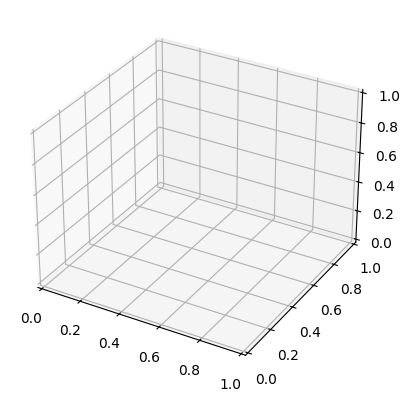

In [38]:
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
t = jnp.ones_like(mesh[:, 0:1]) * 3.0
dphi_dt = vmap(pinn.net_speed, in_axes=(None, 0, 0))(params, mesh, t)

idx = jnp.where(dphi_dt > 0.0)[0]
mesh = mesh[idx]
dphi_dt = dphi_dt[idx]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(mesh[:, 0], mesh[:, 1], mesh[:, 2], c=dphi_dt, cmap="coolwarm")


In [9]:
vmap(pinn.net_speed, in_axes=(None, 0, 0))(params_noirr, mesh, t/cfg.Tc).max()

Array(-1.3173796e-05, dtype=float32)